In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from PIL import Image

In [50]:
images = glob.glob("copy_10000/10000_images/*.png")
mask = glob.glob("masks_colorés_10000/*.png")

In [51]:
print(images[:5])
print('-------------------')
print(mask[:5])

['copy_10000/10000_images/AWGKZDAL_Grey Heron_68.png', 'copy_10000/10000_images/FPBCHBQT_Asian Glossy Starling Bird_40.png', 'copy_10000/10000_images/BAGBNFGA_Whale_123.png', 'copy_10000/10000_images/AIOPYMVW_Eurasian Wren Bird_10.png', 'copy_10000/10000_images/AAKLZWUH_Bird_Preening_0.png']
-------------------
['masks_colorés_10000/AWGKZDAL_Grey Heron_68.png', 'masks_colorés_10000/FPBCHBQT_Asian Glossy Starling Bird_40.png', 'masks_colorés_10000/BAGBNFGA_Whale_123.png', 'masks_colorés_10000/AIOPYMVW_Eurasian Wren Bird_10.png', 'masks_colorés_10000/AAKLZWUH_Bird_Preening_0.png']


In [52]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,copy_10000/10000_images/AWGKZDAL_Grey Heron_68...,masks_colorés_10000/AWGKZDAL_Grey Heron_68.png
1,copy_10000/10000_images/FPBCHBQT_Asian Glossy ...,masks_colorés_10000/FPBCHBQT_Asian Glossy Star...
2,copy_10000/10000_images/BAGBNFGA_Whale_123.png,masks_colorés_10000/BAGBNFGA_Whale_123.png
3,copy_10000/10000_images/AIOPYMVW_Eurasian Wren...,masks_colorés_10000/AIOPYMVW_Eurasian Wren Bir...
4,copy_10000/10000_images/AAKLZWUH_Bird_Preening...,masks_colorés_10000/AAKLZWUH_Bird_Preening_0.png
5,copy_10000/10000_images/EJSGMPTK_Singing Night...,masks_colorés_10000/EJSGMPTK_Singing Nightinga...
6,copy_10000/10000_images/DQXOQEOD_Common Snipe_...,masks_colorés_10000/DQXOQEOD_Common Snipe_68.png
7,copy_10000/10000_images/ANGTGPKK_Black-Winged ...,masks_colorés_10000/ANGTGPKK_Black-Winged Stil...
8,copy_10000/10000_images/BRZFFKOU_Yellowhammer ...,masks_colorés_10000/BRZFFKOU_Yellowhammer Youn...


In [53]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.2)

In [244]:
datagen = ImageDataGenerator(width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            fill_mode='nearest',
                            rescale=1./255)

In [55]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=2,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=2,
                                    class_mode=None
)

Found 7094 validated image filenames.
Found 7094 validated image filenames.


In [56]:
image_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=2,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=2,
                                    class_mode=None
)

Found 1774 validated image filenames.
Found 1774 validated image filenames.


In [125]:
print(type(mask_validation))

<class 'keras.preprocessing.image.DataFrameIterator'>


In [57]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)

In [ ]:
def buildEncoder(input_shape = (256,256,3)):
    
    try:
            VGG16_ = keras.applications.VGG16(
                include_top=False,
                weights="imagenet",
                input_shape=input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
                VGG16_.get_layer(layer_name).output for layer_name in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

    except Exception as e:
            print((f"Unable to buildEncoder!\n{e}"))

    return encoder_model

In [ ]:
def buildUnet(input_shape=(256,256,3), dropout_training=True):
        
        try:

            unet_input = keras.Input(
                shape=input_shape, name="unet_input_layer"
            )

            x = unet_input


            encoder_model = buildEncoder(input_shape)
            all_encoder_layer_outputs = encoder_model(x)

            encoded_img = all_encoder_layer_outputs[-1]

            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5, 9, 13, 17]]


            decoder_filters = int(encoded_img.shape[-1])
            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)
            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=2,
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=0.5, seed=123
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=1,
                kernel_size=3,
                strides=(1, 1),
                padding="same",
                activation="sigmoid",
            )(decoded_img)
            unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")
            
            return unet
        
        except Exception as e:
            print((f"Unable to buildUnet!\n{e}"))


In [60]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)
keras.utils.get_custom_objects()['dice_coef'] = dice_coef
keras.utils.get_custom_objects()['dice_coef_loss'] = dice_coef_loss
keras.utils.get_custom_objects()['bce_dice_loss'] = bce_dice_loss

In [61]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='dice_coef', patience=30)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='vgg16_checkpoint_256.h5', monitor='dice_coef', save_best_only=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=2)

In [62]:
model = buildUnet(input_shape=(256, 256, 3))

In [63]:
model.summary()

Model: "Unet_VGG16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 unet_input_layer (InputLayer)  [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 256, 256, 3  14714688    ['unet_input_layer[0][0]']       
                                ),                                                                
                                 (None, 256, 256, 6                                               
                                4),                                                               
                                 (None, 256, 256, 6                                      

In [64]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [65]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    validation_steps=len(data_val) /2,
    steps_per_epoch=len(data_train) /2,
    callbacks=[early_stopping_callback,checkpoint_callback,reduce_lr_callback]
)

Epoch 1/30


/home/p2m/.local/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3547/3547 [==============================] - 6941s 2s/step - loss: 0.8632 - dice_coef: 0.3299 - accuracy: 0.8579 - val_loss: 0.7984 - val_dice_coef: 0.3749 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 2/30
3547/3547 [==============================] - 6930s 2s/step - loss: 0.7991 - dice_coef: 0.3808 - accuracy: 0.8630 - val_loss: 0.8050 - val_dice_coef: 0.3723 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 3/30
3547/3547 [==============================] - 6930s 2s/step - loss: 0.7848 - dice_coef: 0.3910 - accuracy: 0.8640 - val_loss: 0.7695 - val_dice_coef: 0.3936 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 4/30
3547/3547 [==============================] - 6929s 2s/step - loss: 0.7676 - dice_coef: 0.4042 - accuracy: 0.8646 - val_loss: 0.7869 - val_dice_coef: 0.4026 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 5/30
3547/3547 [==============================] - 6926s 2s/step - loss: 0.7458 - dice_coef: 0.4189 - accuracy: 0.8662 - val_loss: 0.7436 - val_dice_coef: 0.4171 - val_accuracy: 0.8684 - lr: 5.0

In [67]:
np.save('my_history.npy',history.history)

In [114]:
model.save('U-Net_model')

INFO:tensorflow:Assets written to: U-Net_model/assets


INFO:tensorflow:Assets written to: U-Net_model/assets


In [69]:
history=np.load('my_history.npy', allow_pickle=True).item()

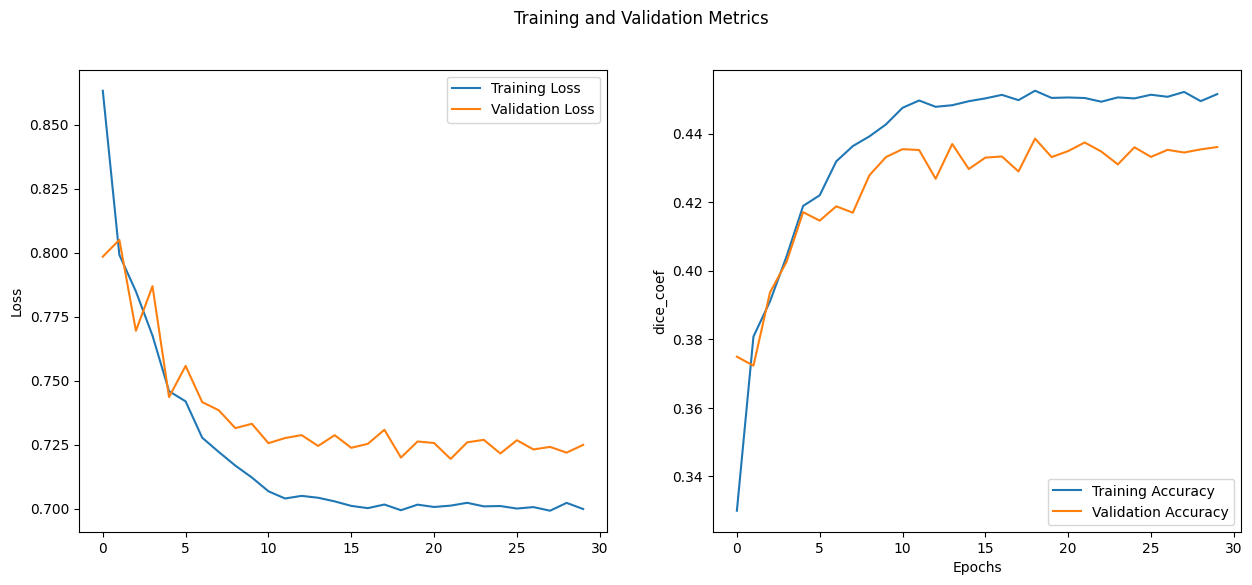

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))

ax1.plot(history['loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['dice_coef'], label='Training Accuracy')
ax2.plot(history['val_dice_coef'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('dice_coef')
ax2.legend()

plt.suptitle('Training and Validation Metrics')
plt.show()

In [245]:
image_test=datagen.flow_from_dataframe(data_test,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=False,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=2,
                                    class_mode=None
                                    
)
mask_test=datagen.flow_from_dataframe(data_test, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=False,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=2,
                                    class_mode=None
)

Found 986 validated image filenames.
Found 986 validated image filenames.


In [246]:
print(len(mask_test))

493


In [247]:
test_gen=zip(image_test,mask_test)

In [248]:
results = model.evaluate_generator(test_gen, steps= 2)


/tmp/ipykernel_3473715/54952436.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results = model.evaluate_generator(test_gen, steps= 2)


In [249]:
print(results)

[0.7003936767578125, 0.36416196823120117, 0.9456138610839844]


In [250]:
predictions = model.predict(image_test[433])
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
1/1 [==============================] - 1s 1s/step
predictions shape: (2, 256, 256, 1)


In [ ]:
import os
import numpy as np
from PIL import Image

output_directory = "predicted_masks_unet"
os.makedirs(output_directory, exist_ok=True)

for i in range(len(image_test)):
    predictions = model.predict(image_test[i])
    predicted_mask = predictions[0]

    predicted_mask_binary = (predicted_mask.squeeze() > 0.5).astype(np.uint8) * 255

    output_filename = os.path.join(output_directory, f"predicted_mask_{i}.png")
    Image.fromarray(predicted_mask_binary).save(output_filename)

    true_mask = mask_test[i]
    loss = model.evaluate(image_test[i], true_mask, verbose=0)[0]

    accuracy = model.evaluate(image_test[i], true_mask, verbose=0)[1]

    print(f"Image {i}: Loss={loss}, Accuracy={accuracy}")

print("Predicted masks saved in:", output_directory)


1/1 [==============================] - 1s 1s/step
Image 0: Loss=0.620529055595398, Accuracy=0.25764480233192444
1/1 [==============================] - 1s 975ms/step
Image 1: Loss=0.9771535992622375, Accuracy=0.17149288952350616
1/1 [==============================] - 1s 942ms/step
Image 2: Loss=0.8957816362380981, Accuracy=0.37645861506462097
1/1 [==============================] - 1s 962ms/step
Image 3: Loss=0.8740614652633667, Accuracy=0.2786795496940613
1/1 [==============================] - 1s 981ms/step
Image 4: Loss=0.7133467793464661, Accuracy=0.46476998925209045
1/1 [==============================] - 1s 1000ms/step
Image 5: Loss=0.6839029788970947, Accuracy=0.45183202624320984
1/1 [==============================] - 1s 985ms/step
Image 6: Loss=0.9052084684371948, Accuracy=0.38899779319763184
1/1 [==============================] - 1s 917ms/step
Image 7: Loss=0.638054609298706, Accuracy=0.4669320583343506
1/1 [==============================] - 1s 988ms/step
Image 8: Loss=0.781573891

1/1 [==============================] - 1s 590ms/step


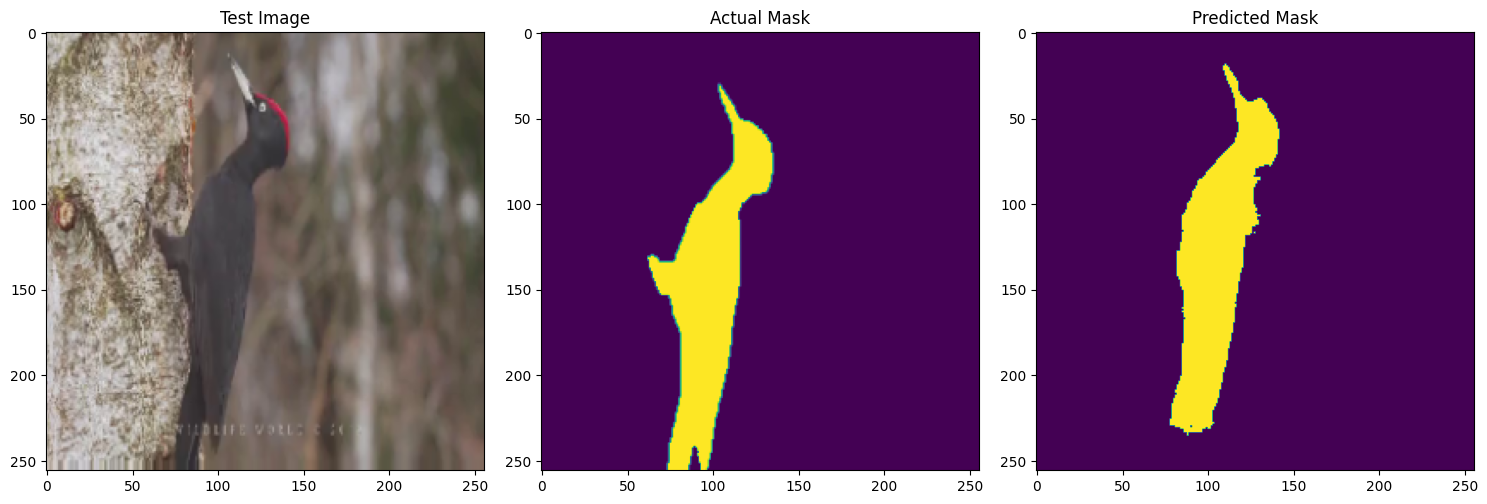

In [ ]:
import random

image, mask = next(test_gen)
image = np.array(image)
mask = np.array(mask)

random_index = random.randint(0, len(image) - 1)

img = image[random_index]
mask = mask[random_index]

img = img[np.newaxis, ...]

pred_y = model.predict(img)
predicted_mask = pred_y[0]

predicted_mask_binary = (predicted_mask.squeeze() > 0.5).astype(np.uint8) * 255


pred_mask = predicted_mask_binary[..., tf.newaxis]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img[0])  
axes[0].set_title('Test Image')

axes[1].imshow(mask[:, :, 0])  
axes[1].set_title('Actual Mask')

axes[2].imshow(pred_mask[:, :, 0])  
axes[2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()
